# [TPS]Dec-2021(14 Baseline Models)
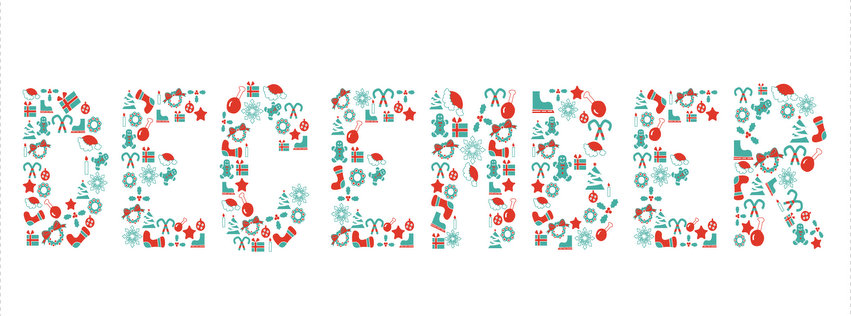
## Dataset
For each monthly competition, we'll be offering Kaggle Merchandise for the top three teams. And finally, because we want these competitions to be more about learning, we're limiting team sizes to 3 individuals.

The dataset is used for this competition is synthetic, but based on a real dataset and generated using a CTGAN. This dataset is based off of the original Forest Cover Type Prediction competition

# Table of Contents
<a id="toc"></a>
- [1. Imports](#1)
- [2. Load Data](#2)
- [3. Target Distribution](#3)
- [4. Function for confusion matrix and classification report](#2)
- [5. Modelling](#2)
    - [5.1 Linear SVC](#5.1)
    - [5.2 Decision Tree](#5.2)
    - [5.3 Random Forest](#5.3)
    - [5.4 ADA Boost](#5.4)
    - [5.5 Bagging Classifier](#5.5)
    - [5.6 Extra Trees](#5.6)
    - [5.7 Gradient Boosting](#5.7)
    - [5.8 Light Gradient Boosting](#5.8)
    - [5.9 XGB](#5.9)
    - [5.10 SGD Classifier](#5.10)
    - [5.11 Ridge](#5.11)
    - [5.12 Passive Aggresive](#5.12)
    - [5.13 Perceptron](#5.13)
    - [5.14 MLP](#5.14)
- [6. Scores](#6)
- [6. Feature Importance Analysis](#7)

.
## Observations
- num_classes = 7
- Highly Imbalanced dataset, with soil type 5 having only 1 example
- Saw some correlations among the features with Elavation having a high Correlation with the target variable
- No of models fitted - 14
- Boosting and tree based classifiers performed much better although each one of them needs to be finetuned as lots of FP,FN .
- Weighted classes shall be used as regularizers for better results.
- Also a NN based model can be trained and then further optimized as we have seen that NN models are performing better these days in TPS.
- A basic analyis of correlation was done in the end of the notebook, took top 15 features, SHAP notebook out soon.

## Contact

- [Click here ](https://twitter.com/bambose_) - to connect me on twitter
- [Click here](https://www.kaggle.com/datastrophy/tps-12-21-xgb-optuna-tutorial-study-vis/edit) to visit  TPS-12/21[Xgb-optuna-tutorial+(study vis)]











<a id="1"></a>
## Imports

In [ ]:
import pandas as pd
import datatable as dt
import numpy as np
from sklearn.preprocessing import MinMaxScaler,StandardScaler, RobustScaler
import plotly.express as px
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier, LogisticRegression, PassiveAggressiveClassifier,RidgeClassifierCV
from sklearn.neural_network import MLPClassifier
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score, log_loss, roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.ensemble import (AdaBoostClassifier,BaggingClassifier,ExtraTreesClassifier,GradientBoostingClassifier,RandomForestClassifier,VotingClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, log_loss, roc_auc_score
from sklearn.model_selection import cross_validate,cross_val_score,train_test_split, KFold, GridSearchCV
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns


In [ ]:
#choose colors accordingly
pl1=px.colors.qualitative.swatches()
pl1.show()

In [ ]:
print(px.colors.qualitative.Plotly)

In [ ]:
import datatable as dt
def reduce_memory_usage(df, verbose=True):
    numerics = ["int8", "int16", "int32", "int64", "float16", "float32", "float64"]
    start_mem = df.memory_usage().sum() / 1024 ** 2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if (
                    c_min > np.finfo(np.float16).min
                    and c_max < np.finfo(np.float16).max
                ):
                    df[col] = df[col].astype(np.float16)
                elif (
                    c_min > np.finfo(np.float32).min
                    and c_max < np.finfo(np.float32).max
                ):
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print(
            "Mem. usage decreased to {:.2f} Mb ({:.1f}% reduction)".format(
                end_mem, 100 * (start_mem - end_mem) / start_mem
            )
        )
    return df

<a id="2"></a>
## Load Data

In [ ]:
%%time
train = dt.fread('../input/tabular-playground-series-dec-2021/train.csv').to_pandas().drop('Id', axis=1)
train = reduce_memory_usage(train)
test = dt.fread('../input/tabular-playground-series-dec-2021/test.csv').to_pandas().drop('Id', axis=1)
test = reduce_memory_usage(test)
ss = dt.fread('../input/tabular-playground-series-dec-2021/sample_submission.csv').to_pandas()
ss = reduce_memory_usage(ss)

In [ ]:
categorical_features=[]
numerical_features=[]
for i in test.columns:
    if test[i].dtype=='int16' or 'int8':
        numerical_features.append(i)
    elif i!='target':
        categorical_features.append(i)

print(f'Continious features obtained {len(numerical_features)} and categorical features obtained are {len(categorical_features)}')

<a id="3"></a>
## Target distribution

In [ ]:

pal=['#FFA15A','#00CC96']

fig = px.histogram(train, x="Cover_Type", color="Cover_Type", color_discrete_sequence=px.colors.qualitative.Pastel1)
fig.show()



In [ ]:
%%time
scale = RobustScaler()
#scale = MinMaxScaler()
#scale = StandardScaler()
train[numerical_features]=scale.fit_transform(train[numerical_features])
test[numerical_features]= scale.transform(test[numerical_features])  

print('Data scaled using : ', scale)

In [ ]:
train['Cover_Type'].unique()
print(len(train[train['Cover_Type']==5]))
print(len(train[train['Cover_Type']==4]))


In [ ]:
#lets train only on 10% data and identify what models perform better and then later can develop a piepline for the best performing model.
X=train.drop(['Cover_Type'],axis=1)
y=train.Cover_Type
X_train,X_valid,y_train,y_valid=train_test_split(X,y,train_size=0.1,test_size=0.05,random_state=2001)

In [ ]:
print(len(X_train))

<a id="4"></a>
## Function for confusion matrix and classification report

In [ ]:
def cnf_matrix_and_report(y_validation,y_prediction):
    cf_matrix = confusion_matrix(y_validation, y_prediction)
    sns_plot=sns.heatmap(cf_matrix, annot=True,  cmap='Blues')
    fig = sns_plot.get_figure()
    #fig.savefig("output.png")
    print(classification_report(y_validation, y_prediction))

In [ ]:
accuracy_list=[]
model_list=[]


<a id="5"></a>
## Modelling
<br><hr>
<br>
<a id="5.1"></a>
### Linear SVC

In [ ]:
#1. Linear SVC

model_type='Linear_svc'
linear_svc=LinearSVC()
linear_svc.fit(X_train,y_train)
ypreds=linear_svc.predict(X_valid)
accuracy=accuracy_score(ypreds,y_valid)
print(f'accuracy- {accuracy}')
cnf_matrix_and_report(y_valid,ypreds)
accuracy_list.append(accuracy)
model_list.append(model_type)


<a id="5.2"></a>
### Decision Tree

In [ ]:
#2. Decision Tree
model_type='DecisionTreeClassifier'
dt=DecisionTreeClassifier()
dt.fit(X_train,y_train)
ypreds=dt.predict(X_valid)
accuracy=accuracy_score(ypreds,y_valid)
print(f'accuracy- {accuracy}')
cnf_matrix_and_report(y_valid,ypreds)
accuracy_list.append(accuracy)
model_list.append(model_type)



<a id="5.3"></a>
### Random Forest


In [ ]:
#3. Random Forest

model_type='RandomForestClassifier'
clf=RandomForestClassifier()
clf.fit(X_train,y_train)
ypreds=clf.predict(X_valid)
accuracy=accuracy_score(ypreds,y_valid)
print(f'accuracy- {accuracy}')
cnf_matrix_and_report(y_valid,ypreds)
accuracy_list.append(accuracy)
model_list.append(model_type)



<a id="5.4"></a>
### AdaBoost Classifier


In [ ]:
#4. AdaBoostClassifier

model_type='AdaBoostClassifier'
adb=AdaBoostClassifier()
adb.fit(X_train,y_train)
ypreds=adb.predict(X_valid)
accuracy=accuracy_score(ypreds,y_valid)
print(f'accuracy- {accuracy}')
cnf_matrix_and_report(y_valid,ypreds)
accuracy_list.append(accuracy)
model_list.append(model_type)



<a id="5.5"></a>
### Bagging Classifier


In [ ]:
#5. AdaBoostClassifier

model_type='BaggingClassifier'
bagging=BaggingClassifier()
bagging.fit(X_train,y_train)
ypreds=bagging.predict(X_valid)
accuracy=accuracy_score(ypreds,y_valid)
print(f'accuracy- {accuracy}')
cnf_matrix_and_report(y_valid,ypreds)
accuracy_list.append(accuracy)
model_list.append(model_type)



<a id="5.6"></a>
### Extra Trees Classifier


In [ ]:
#6. ExtraTreesClassifier
model_type='ExtraTreesClassifier'
etc=ExtraTreesClassifier()
etc.fit(X_train,y_train)
ypreds=etc.predict(X_valid)
accuracy=accuracy_score(ypreds,y_valid)
print(f'accuracy- {accuracy}')
cnf_matrix_and_report(y_valid,ypreds)
accuracy_list.append(accuracy)
model_list.append(model_type)



<a id="5.7"></a>
### Gradient Boosting


In [ ]:
#7. GradientBoostingClassifier
model_type='GradientBoostingClassifier'
gbc=GradientBoostingClassifier()
gbc.fit(X_train,y_train)
ypreds=gbc.predict(X_valid)
accuracy=accuracy_score(ypreds,y_valid)
print(f'accuracy- {accuracy}')
cnf_matrix_and_report(y_valid,ypreds)
accuracy_list.append(accuracy)
model_list.append(model_type)



<a id="5.8"></a>
### Light Gradient Boosting


In [ ]:
#8. LGBMClassifier
model_type='LGBMClassifier'
lgbm=LGBMClassifier()
lgbm.fit(X_train,y_train)
ypreds=lgbm.predict(X_valid)
accuracy=accuracy_score(ypreds,y_valid)
print(f'accuracy- {accuracy}')
cnf_matrix_and_report(y_valid,ypreds)
accuracy_list.append(accuracy)
model_list.append(model_type)



<a id="5.9"></a>
### XgBoost


In [ ]:
#9 XGBClassifier
model_type='XGBClassifier'
xgb=XGBClassifier()
xgb.fit(X_train,y_train)
ypreds=xgb.predict(X_valid)
accuracy=accuracy_score(ypreds,y_valid)
print(f'accuracy- {accuracy}')
cnf_matrix_and_report(y_valid,ypreds)
accuracy_list.append(accuracy)
model_list.append(model_type)



<a id="5.10"></a>
### Stocastic gradient Descent


In [ ]:
#10 SGDClassifier
model_type='SGDClassifier'
sgd=SGDClassifier()
sgd.fit(X_train,y_train)
ypreds=sgd.predict(X_valid)
accuracy=accuracy_score(ypreds,y_valid)
print(f'accuracy- {accuracy}')
cnf_matrix_and_report(y_valid,ypreds)
accuracy_list.append(accuracy)
model_list.append(model_type)



<a id="5.11"></a>
### Ridge Classifier


In [ ]:
#11 Ridge Classifier
model_type='Ridge Classifier'
rgc=RidgeClassifierCV()
rgc.fit(X_train,y_train)
ypreds=rgc.predict(X_valid)
accuracy=accuracy_score(ypreds,y_valid)
print(f'accuracy- {accuracy}')
cnf_matrix_and_report(y_valid,ypreds)
accuracy_list.append(accuracy)
model_list.append(model_type)



<a id="5.12"></a>
### Perceptron


In [ ]:
#12 Perceptron
model_type='Perceptron'
percp=Perceptron()
percp.fit(X_train,y_train)
ypreds=percp.predict(X_valid)
accuracy=accuracy_score(ypreds,y_valid)
print(f'accuracy- {accuracy}')
cnf_matrix_and_report(y_valid,ypreds)
accuracy_list.append(accuracy)
model_list.append(model_type)



<a id="5.13"></a>
### Passive Aggresive


In [ ]:
#13 passive aggresive
model_type='Passive Aggresive'
pac=PassiveAggressiveClassifier()
pac.fit(X_train,y_train)
ypreds=pac.predict(X_valid)
accuracy=accuracy_score(ypreds,y_valid)
print(f'accuracy- {accuracy}')
cnf_matrix_and_report(y_valid,ypreds)
accuracy_list.append(accuracy)
model_list.append(model_type)



<a id="5.14"></a>
### MLP


In [ ]:
#14 MLP sklearn
model_type='MLP'
mlp=MLPClassifier()
mlp.fit(X_train,y_train)
ypreds=mlp.predict(X_valid)
accuracy=accuracy_score(ypreds,y_valid)
print(f'accuracy- {accuracy}')
cnf_matrix_and_report(y_valid,ypreds)
accuracy_list.append(accuracy)
model_list.append(model_type)


In [ ]:
list_of_tuples = list(zip(model_list, accuracy_list))
df = pd.DataFrame(list_of_tuples, columns = ['Models', 'scores'])
df=df.sort_values(by='scores', ascending=False)
df=df.reset_index(drop=True)


<a id="6"></a>
## Scores plot


In [ ]:
fig = px.bar(df, x='Models', y='scores',color_discrete_sequence=px.colors.qualitative.Pastel)
fig.show()

# My Observations
**14 models fitted.**
We can see that some models performed better than others but there is huge huge class imbalance and that is going to affect the f1 score, also Soil_type =5 has only one example, it's going to be a big task to detect that.

The next step for model training can be finetuning the hyperparams for top 5 models on a single fold and then further full training on 10 fold dataset with including weighted classes.

Also a NN based model can be trained and then further optimized as we have seen that NN models are performing better these days in TPS.


Further more the next step should be get the feature importance of this dataset, we might use a few tecniques to get the important features and then maybe 





<a id="7"></a>
### Feature Importance Analysis

In [ ]:
sns.set(rc = {'figure.figsize':(12,8)})
sns.heatmap(train.corr())

In [ ]:
#Absolute corr
absoulte_corr = pd.DataFrame(np.abs(train).corr()['Cover_Type'])
absoulte_corr=absoulte_corr.sort_values(by='Cover_Type', ascending=False)
top15_absolute=absoulte_corr.head(15).index.tolist()
top15_absolute

In [ ]:
#submitting 1 model.
#NOTE - we haven't used the full dataset , not expecting anything from the LB(lol)
xgb_submission = ss.copy()
ypreds=xgb.predict(test).tolist()
xgb_submission['Cover_Type'] = ypreds
xgb_submission.to_csv("xgbsub.csv",index=None)
xgb_submission.head()
'''
PS - got a score of .0.95056 in public I guess it will overfit on
the hidden test dataset as it was only trained on 10 percent of data with no Fine tuning.
Easy improvements Ahead'''

### Thanks for spending your time while going through this Kernel. 
#### Cheers